# MNIST Classification with K-Means Clustering

This notebook is an example of using K-Means clustering to classify handwritten digits. The model will be trained and evaluated on the MNIST dataset.

Credit to [Github user Sharmaroshan for working through this exercise and writing out some great functions for plotting data in particular](https://github.com/sharmaroshan/MNIST-Using-K-means/blob/master/KMeans%20Clustering%20for%20Imagery%20Analysis%20(Jupyter%20Notebook).ipynb)

In [214]:
import sys
import sklearn
import matplotlib
import numpy as np

In [215]:
# Keras is an ML Library used extensively in TensorFlow. Don't worry about it for now, its just how we're getting the MNIST dataset
from keras.datasets import mnist

# Set a random seed so that each time we run the code we get the same results
random_state=24

# In the ML space, you'll see the variables below very often. X refers to the input data, Y refers to the output data. In this case, X contains the digit images and Y are the labels associated with them.
# The other split is train and test. Our models will be trained (or more accurately for k-means, "fitted") on the x_train and y_train dataset. When we want to figure out how well the model will perform
# in the real world, we'll evaluate it on the x_test and y_test dataset. 

# By splitting out our test data from training, we're depriving our model of extra datapoints that it could use to improve its understanding. So why are we splitting them up to begin with?
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# The "shapes" we're printing are the dimensions of the tensors representing our image.
# Since our inputs are 28x28 pixel images, and there are 60000 in the training dataset, we'd expect our input tensor to be 10000 X 28 X 28 values. 
# Our output label is just a single value, so we can think of it like a 60000 item array. 
print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [216]:
# Our testing data is a smaller subset than our training data. After all, we want to give our model the most data we can to learn patterns.
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


## Visualizing Our Data

The importance of visualizing data in data science and machine learning cannot be overstated. Humans are bad at comprehending data when its presented in giant, context-less rows and columns. But getting a visualization will tell you a ton about the data your working with. It can also be helpful in troubleshooting why a model is making the decisions that it is. 

In [217]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

/var/folders/tg/6bbhvws15x76j30gmgpzdgvh0000gp/T/ipykernel_13437/1688779527.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


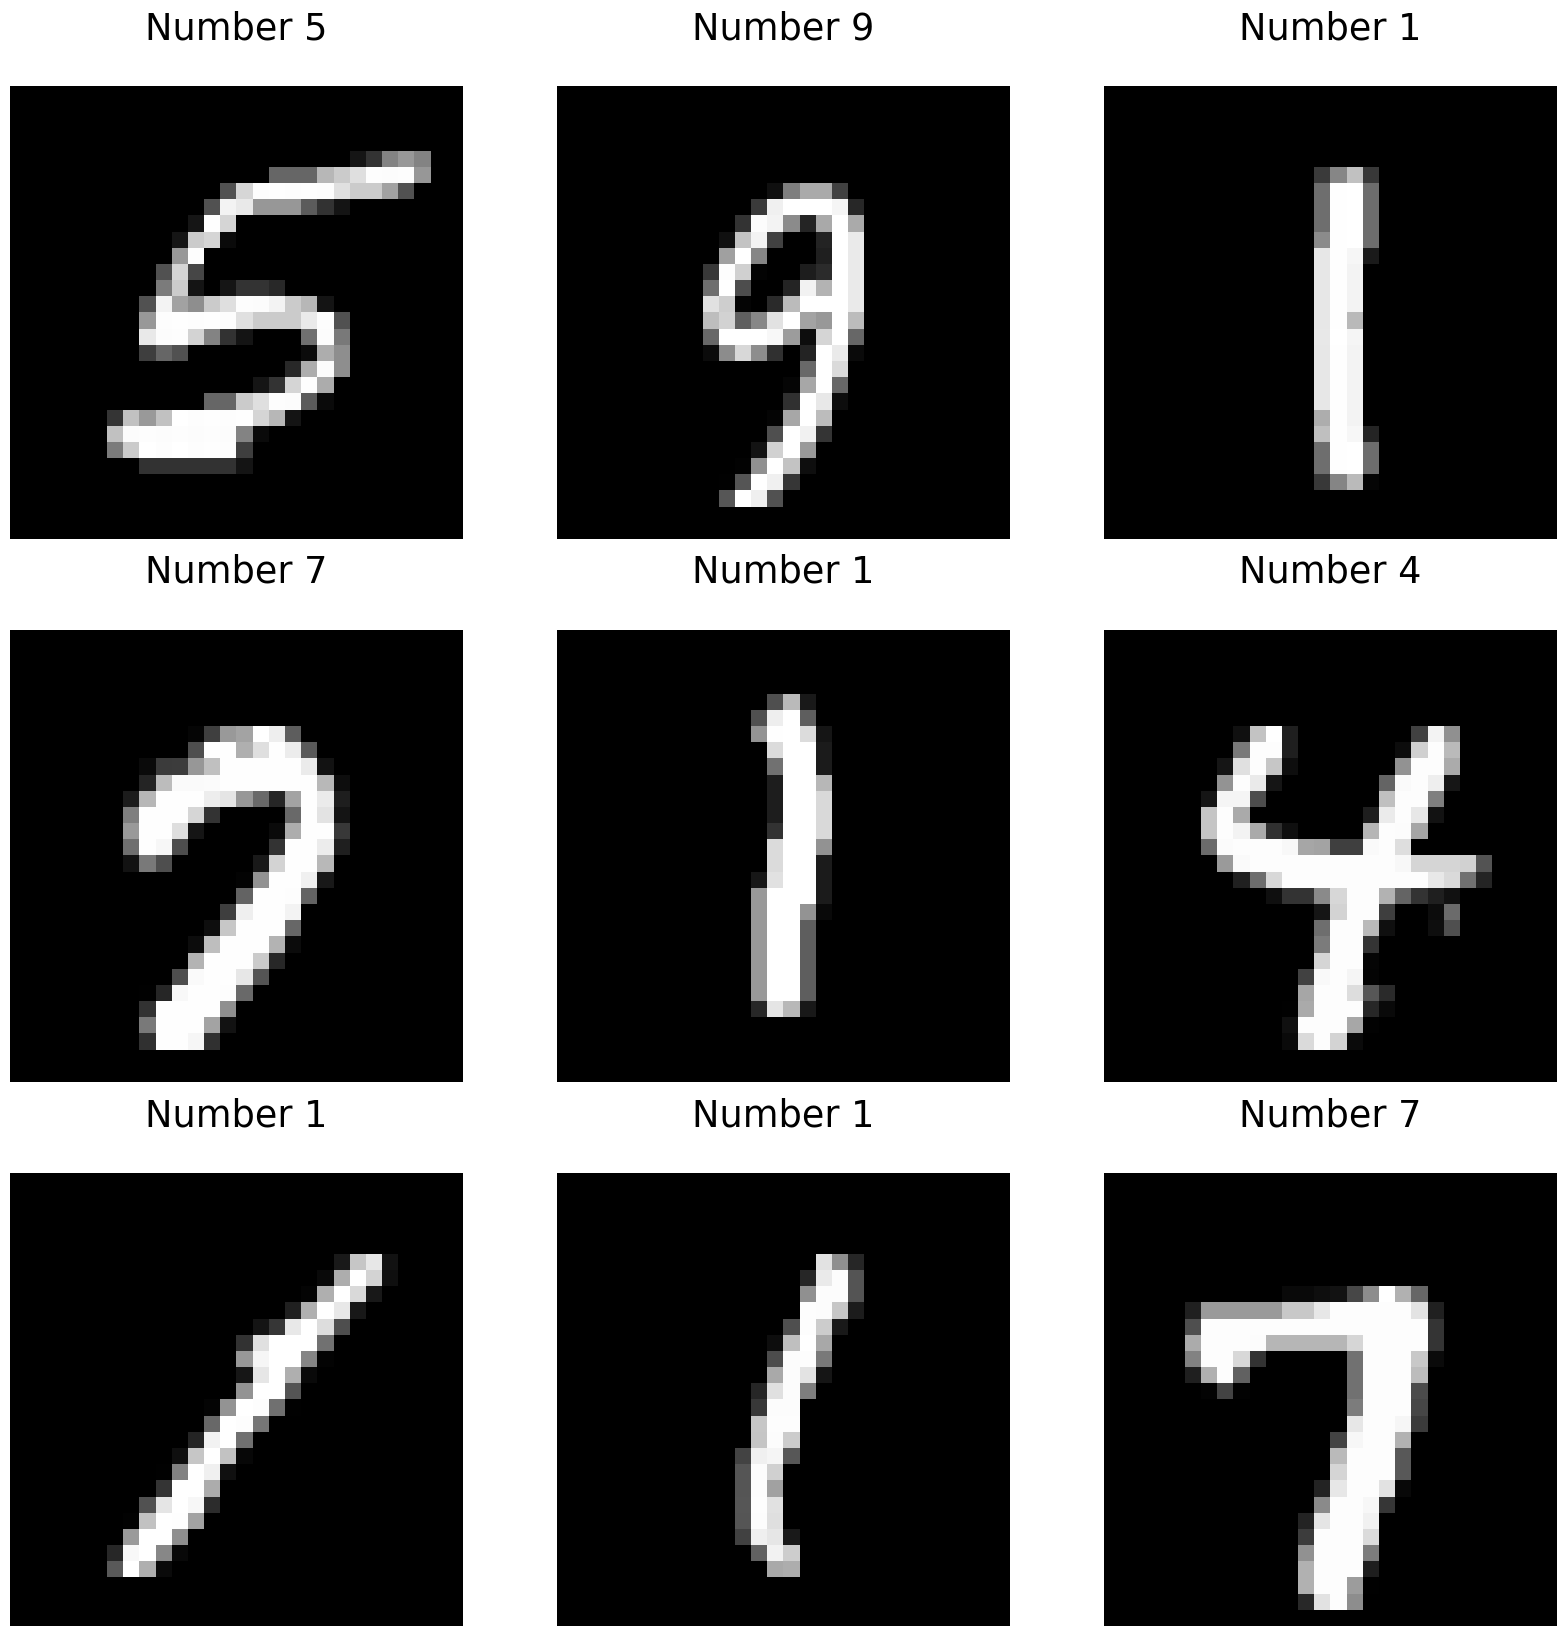

In [218]:
# create a pyplot showing 9 images from the dataset to get a sense of what we're working with.
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
plt.gray()
random_index = np.random.choice(x_train.shape[0], 9, replace=False)

# For each subplot, take an image from the dataset and plot it
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[random_index[i]])
    ax.axis('off')
    ax.set_title(f'Number {y_train[random_index[i]]}')

# display the figure
    fig.show()

# Start Clustering!
We've got data, and SKLearn will give us a ready-made K-Means algorithm out of the box. So let's just fit it!

In [219]:
# We'll use mini-batch K-Means because our dataset is big. Don't worry about it, the algorithm works the same way fundamentally.
from sklearn.cluster import MiniBatchKMeans

# We need a minimum number of clusters equal to our unique labels. Numpy can help us by getting the total unique values in our label dataset
n_digits = len(np.unique(y_train))
print(f"Total unique labels: {n_digits}")


# Initialize the KMeans model
kmeans = MiniBatchKMeans(n_clusters=n_digits)
try:
    kmeans.fit(x_train)
except Exception as e:
    print("ERROR: Could not train on this dataset!")
    print(e)


Total unique labels: 10
ERROR: Could not train on this dataset!
Found array with dim 3. MiniBatchKMeans expected <= 2.


## Great at Colors, Bad at Shapes
Oops! Our KMeans algorithm doesn't like our data. It looks like its "dimensionality (the dim 3 bit)" isn't what K-Means expects. Look at our values we printed earlier. The shapes Keras gave us was (60000, 28, 28). Three dimensions total, two for the 2D image and 1 for the collection of the 60000 different images in the dataset. SKLearn's K-Means algorithm wants a 2D array. Well luckily, this isn't a big deal. We just need to collapse our 2D image into a 1D array.

The author doesn't feel bad about this error at all. If there's any issue that's going to bite you over and over again in this field, input tensor shapes are going to account for easily 50% of them.

In [220]:
# K-Means didn't like our array. Let's squash the images and try again. This step is a vital part of "Pre-Processing" our data, and is a necessary step in basically any ML process
X = x_train.reshape(len(x_train), -1)
Y = y_train

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


Now we've got a 2-D array, one for each image and one for the data inside. Instead of a 28x28 array, we now have a 1D array 784 values wide (28 * 28 = 784). Let's try fitting again.

In [221]:
kmeans = MiniBatchKMeans(n_clusters=n_digits, random_state=random_state)
kmeans.fit(X)

MiniBatchKMeans(n_clusters=10, random_state=24)

In [222]:
kmeans.labels_

array([4, 5, 2, ..., 8, 9, 8], dtype=int32)

## Assign Cluster Labels
K-Means clustering is an unsupervised machine learning method. The labels assigned by the algorithm are unrelated to the digit they hopefully represent. So we need to define a few functions that will map those arbitrary cluster labels to the actual digit they most likely correspond to. Feel free to read the code below, but its not crucial for the exercise.

In [223]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probably label with each cluster in KMeans model and returns a dictionary of clusters assigned to each label
    """

    inferred_labels = {}
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if (len(labels[0]) == 1):
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
        
        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    Returns the predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
    
    return predicted_labels

In [224]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[3 0 4 1 8 6 1 3 1 8 3 1 3 6 1 8 6 8 6 8]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


## Evaluate the Clustering Algorithm
With our new functions, we can determine the accuracy of our clustering model. There are a ton of metrics we can use, accuracy being a solid one for classification excercises. 

In [225]:
from sklearn import metrics

cluster_labels = infer_cluster_labels(kmeans, Y)
predicted_Y = infer_data_labels(kmeans.labels_, cluster_labels)

def calculate_metrics(estimator, data, labels):
    # calculate and print metrics
    print(f'Number of clusters: {estimator.n_clusters}')
    print(f'Inertia: {estimator.inertia_}')
    print(f'Homogeneity: {metrics.homogeneity_score(labels, estimator.labels_)}')

# calculate and print accuracy
print(f'Accuracy: {metrics.accuracy_score(Y, predicted_Y)}')

Accuracy: 0.5210666666666667


# 😰 Well that's not good

50% accuracy! That's not good enough at all. Granted, we are guessing 10 different classes, so a random guess would be 10% likely, but still. The best K-Means benchmark for MNIST is >99% accurate, and while we're not going to get there ourselves, we should be doing way better than 50/50. 

Sorry folks, I buried an important detail. Most ML algorithms, including K-Means, want most numerical feats *scaled*, typically meaning bounded between 0 and 1 or -1 and 1. Let's double check if our data is already scaled.

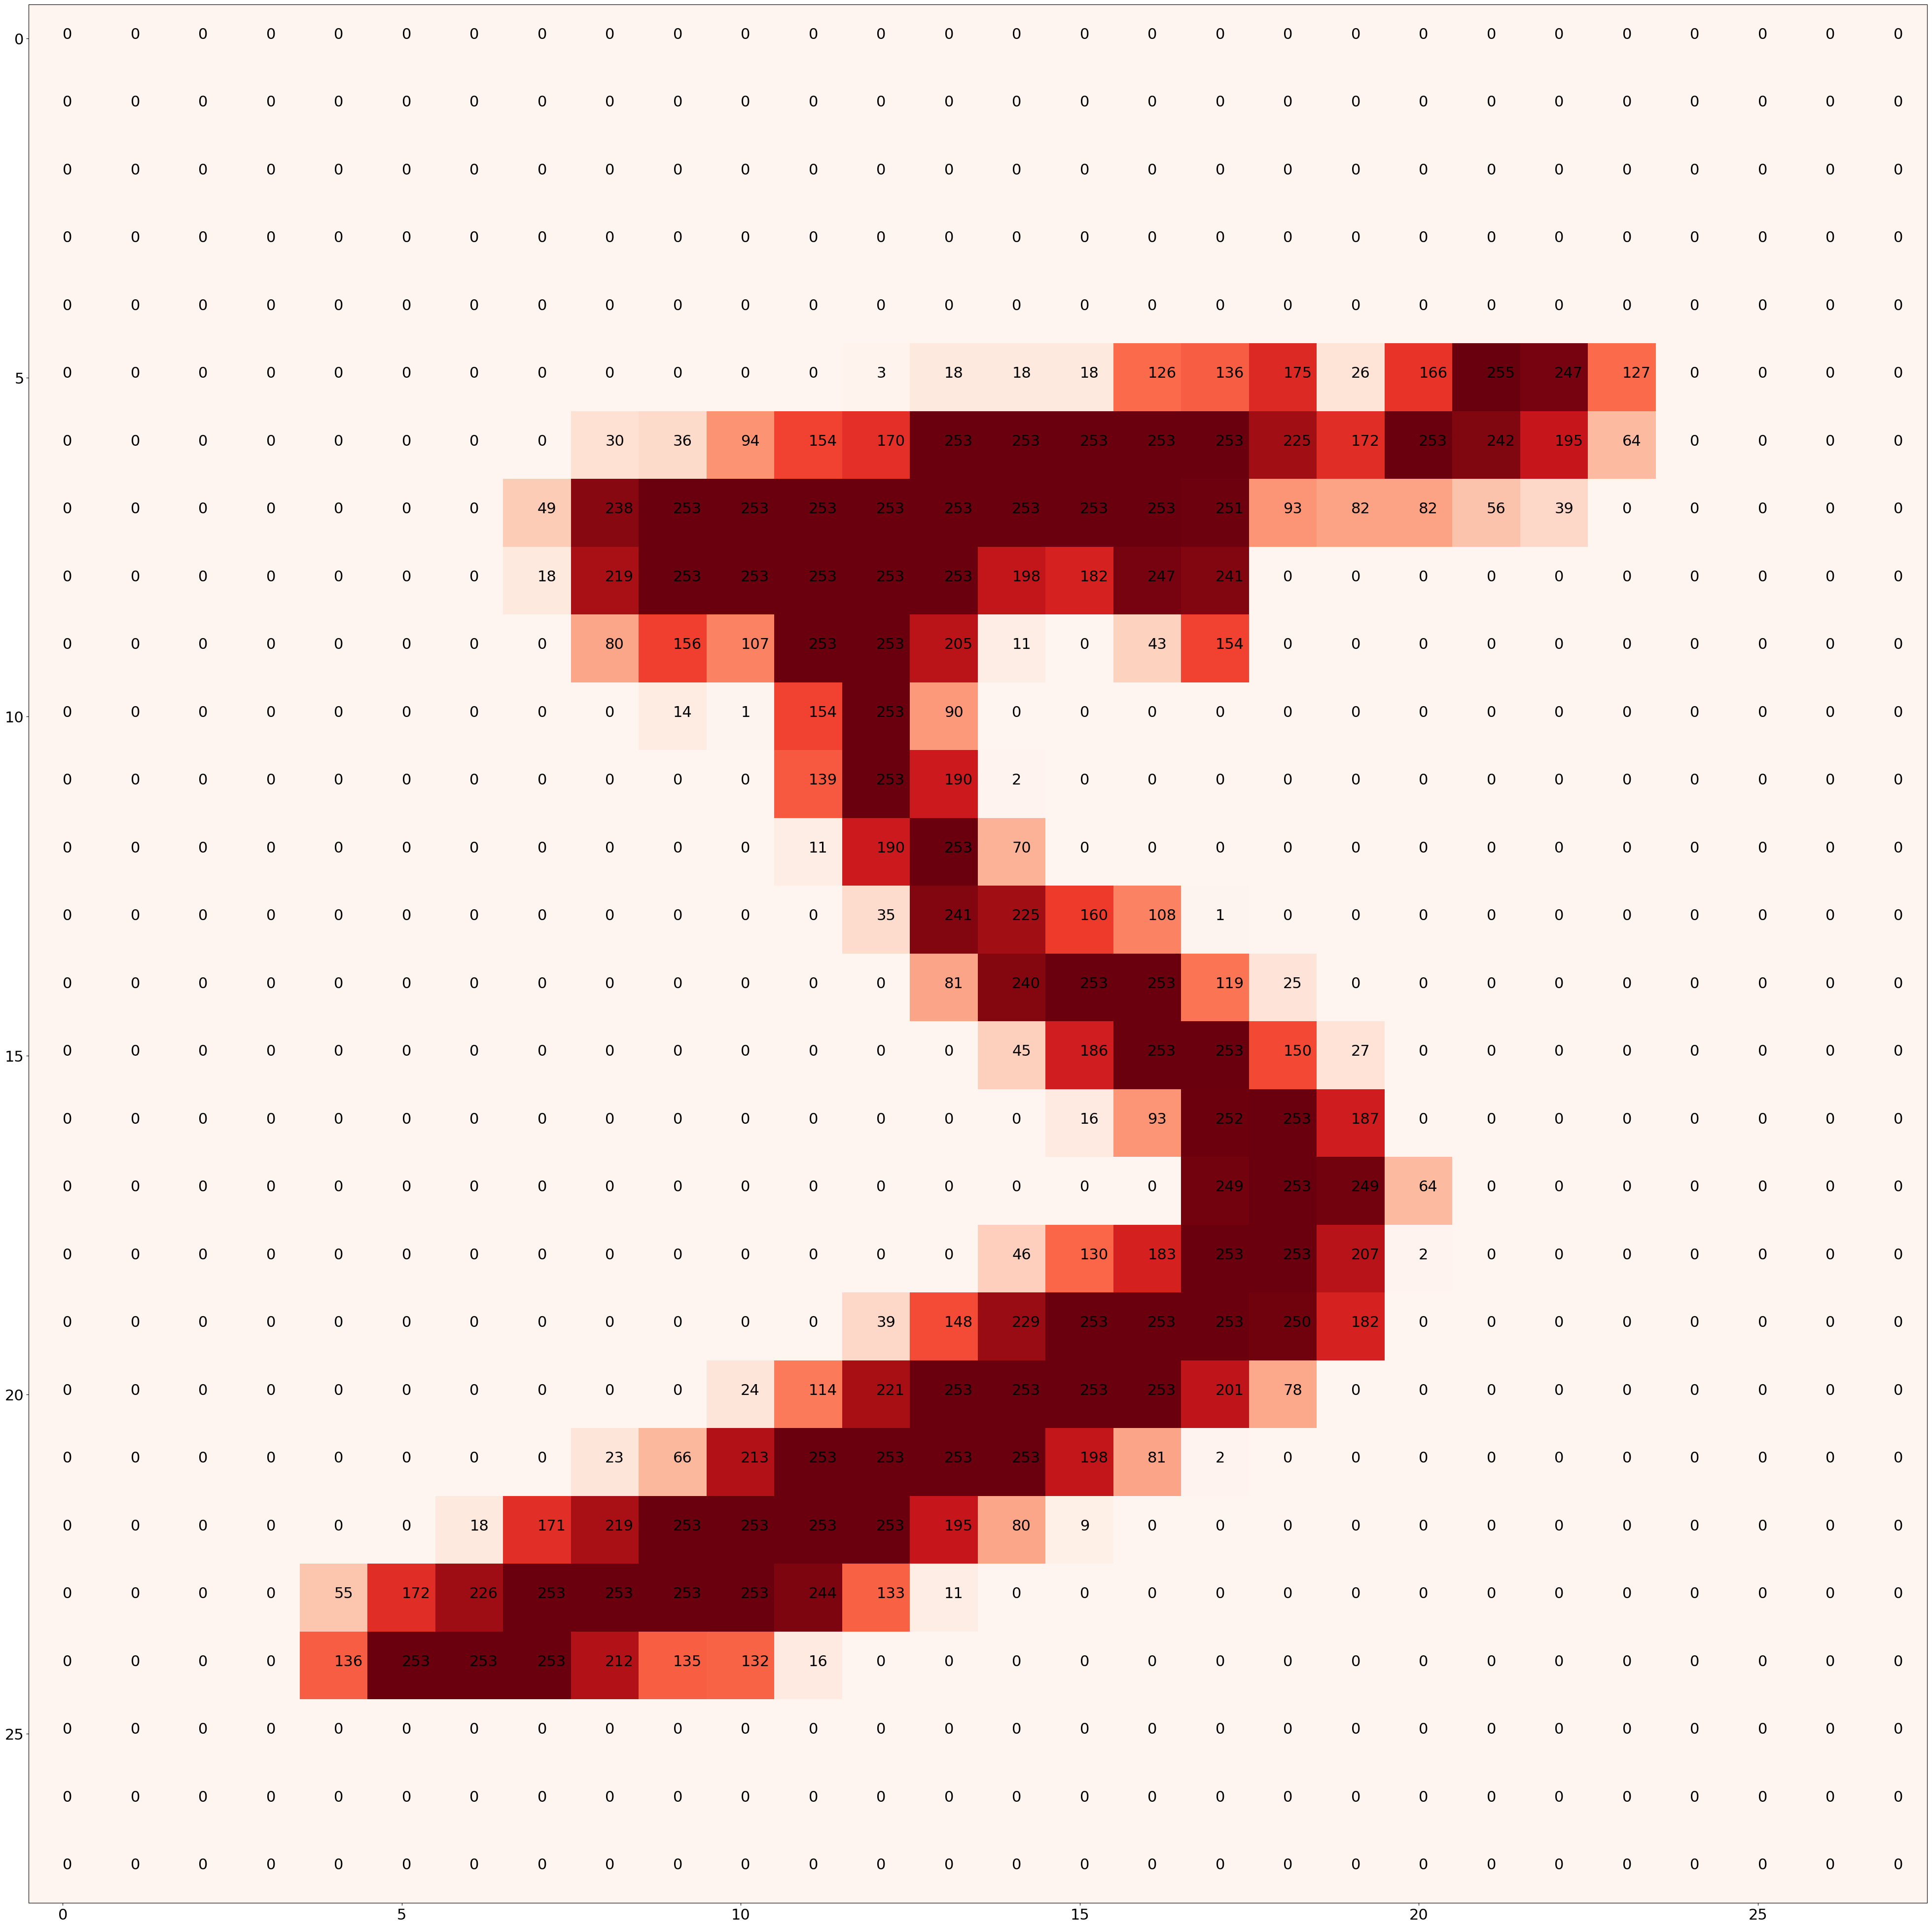

In [226]:
plt.figure(figsize=(50, 50))
fig = plt.imshow(x_train[0], cmap='Reds')
# fig.figsize((50, 50))
ax = fig.axes
font = {'size': 22}
plt.rc('font', **font)
for i in range(28):
    for j in range(28):
        text = ax.text(j, i, x_train[0, i, j])

Yep, that's not scaled for sure. We should get those values set between 0 and 1 and try our k-means again. Luckily, numpy has some handy tools to make our lives easier on that front.

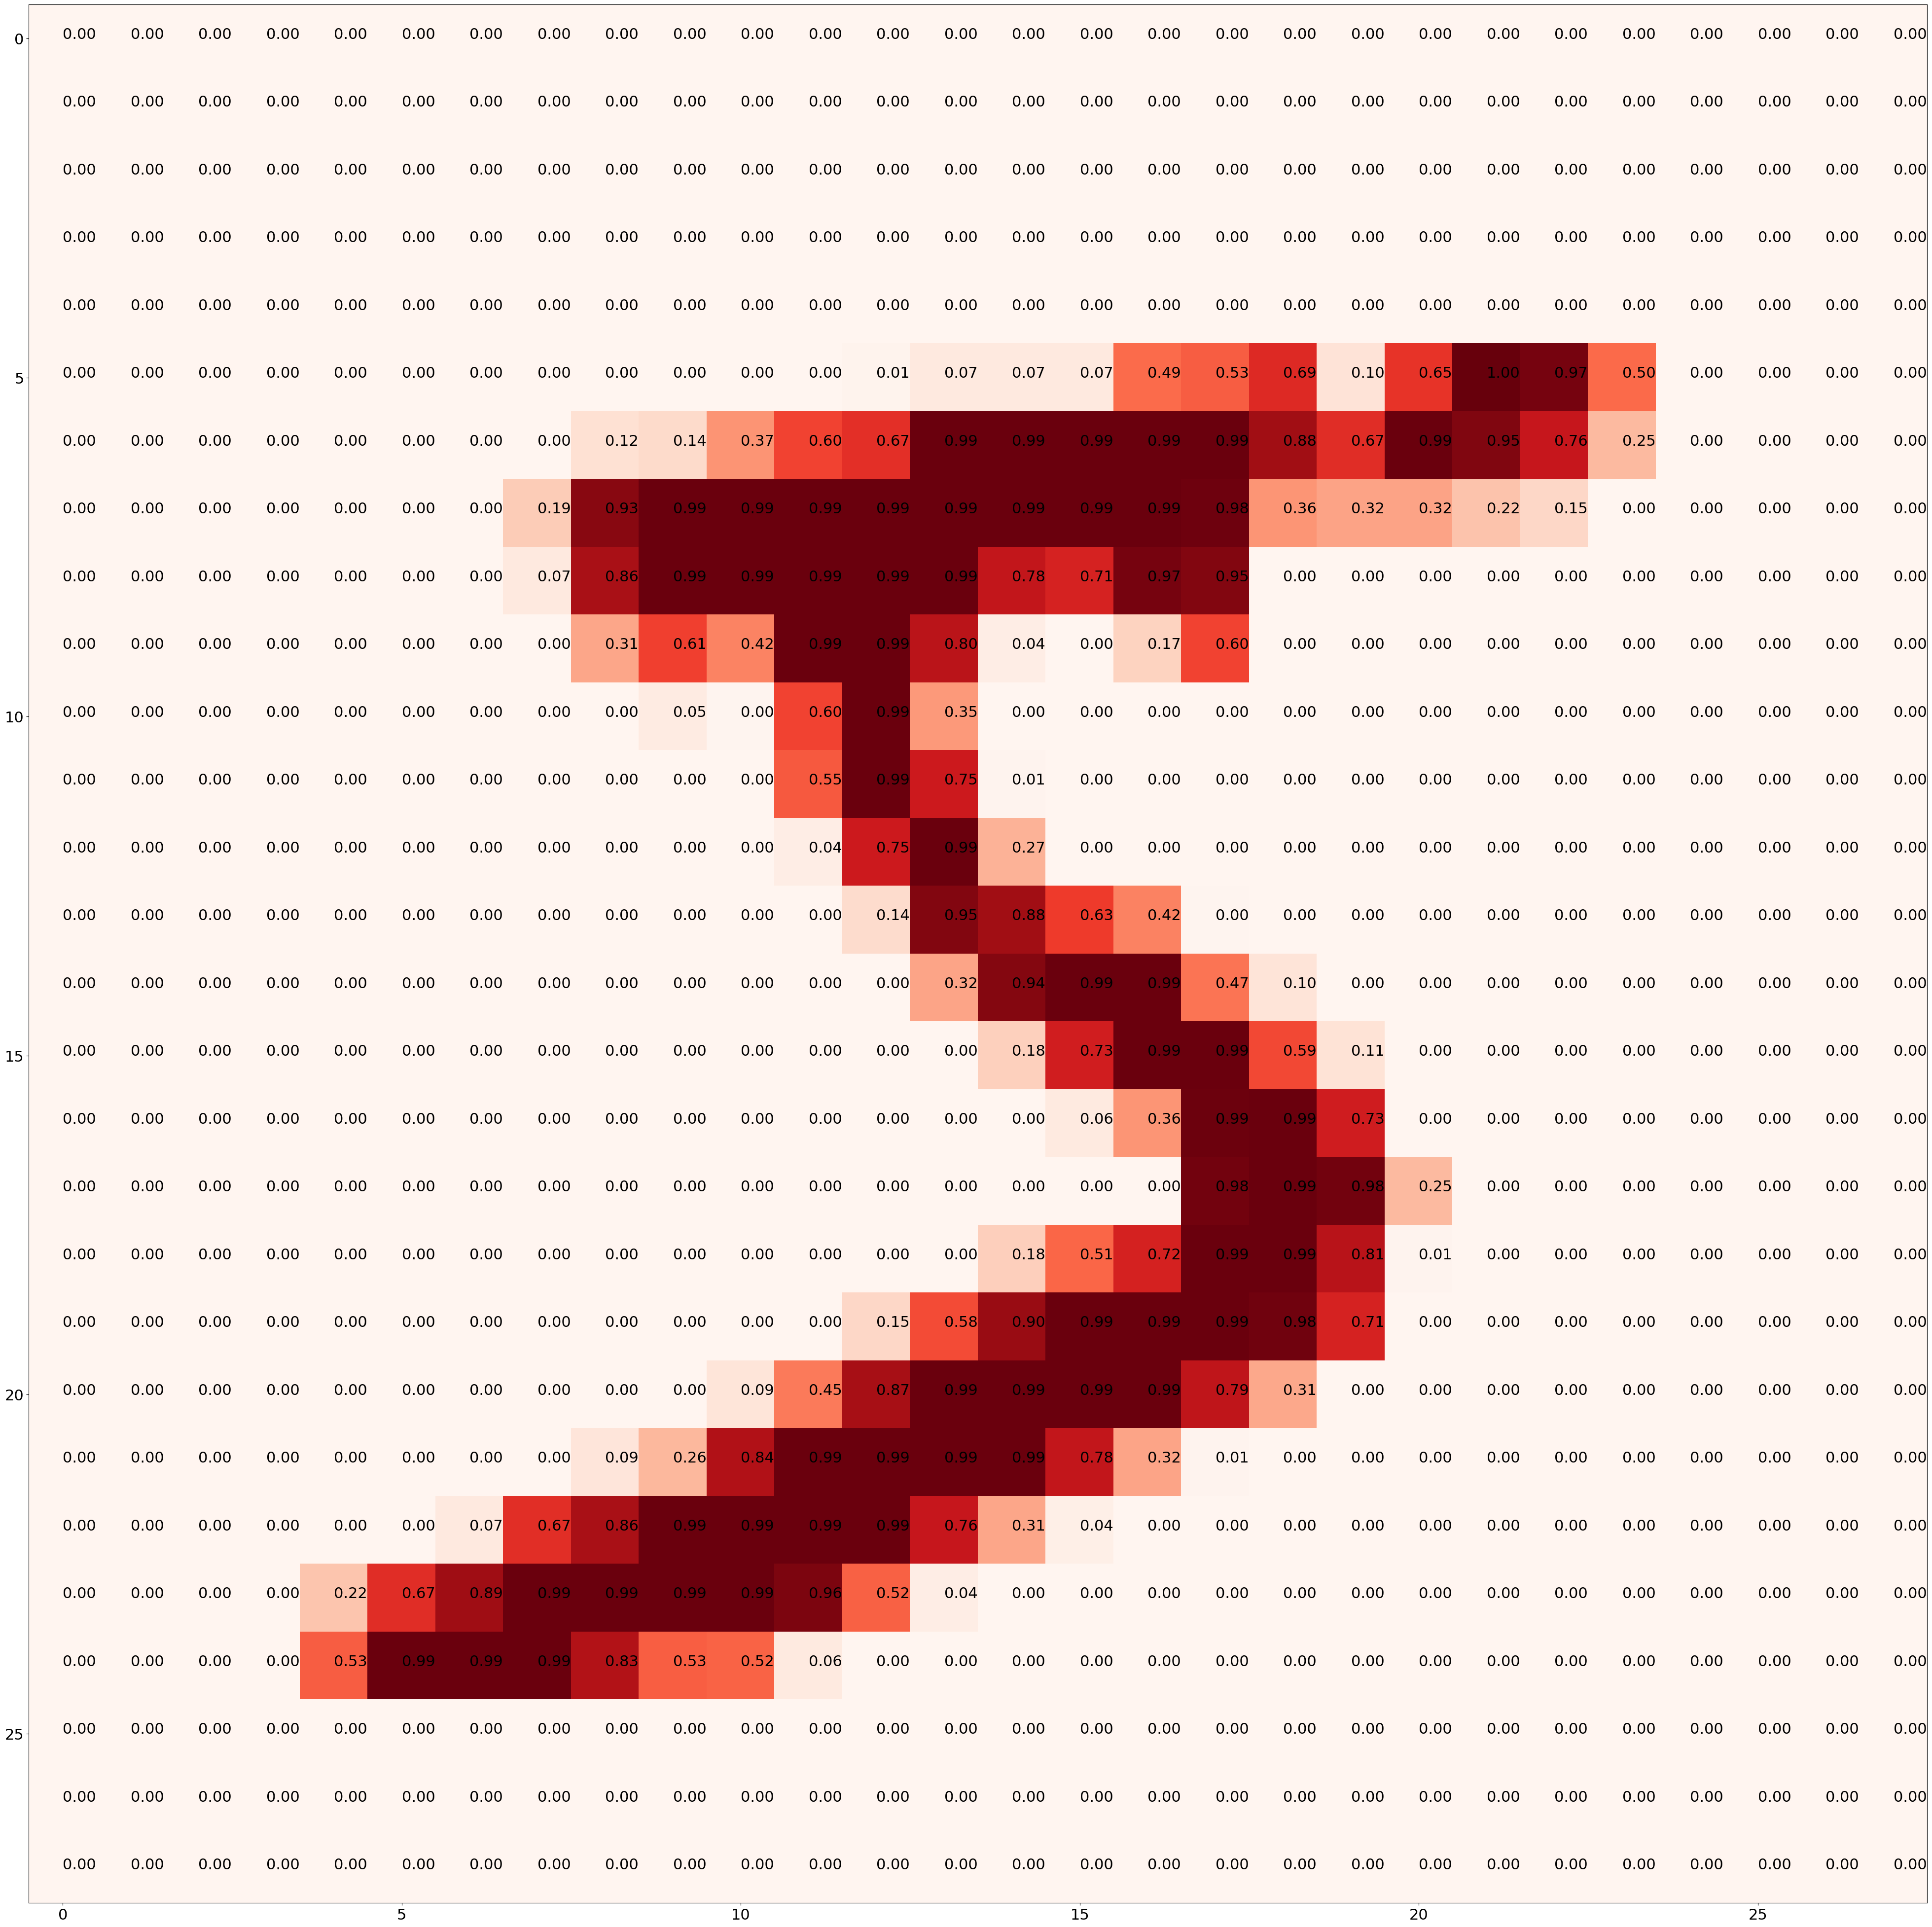

In [227]:
# normalize the data to 0 - 1
x_train = x_train.astype(float) / 255.

plt.figure(figsize=(50, 50))
fig = plt.imshow(x_train[0], cmap='Reds')
ax = fig.axes
font = {'size': 22}
plt.rc('font', **font)
for i in range(28):
    for j in range(28):
        text = ax.text(j, i, f"{x_train[0, i, j]:.2f}")

That's the ticket! We've got our values scaled, let's retrain our k-means model and give it all another shot.

In [228]:
X = X.astype(float) / 255.
kmeans = MiniBatchKMeans(n_clusters=n_digits, random_state=random_state)
kmeans.fit(X)

# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

# calculate and print accuracy
print(f'Accuracy: {metrics.accuracy_score(Y, predicted_Y)}')

[3 0 4 1 8 6 1 3 1 8 3 1 3 6 1 8 6 8 6 8]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
Accuracy: 0.5210666666666667


Whelp. A little better, but 5% improvement is well below what we're looking for. For me, its 90% accuracy or bust. But we've normalized our features, we've got our label assignment functions in tip-top shape. What else can there be?

Well this is where things get a bit unintuitive. We've been making an assumption ever since we trained our first K-Means model. Can you guess what it is?

Why are we assuming that 10 classes is the right number? Sure we need a *minimum* of 10, but there are a whole lot of ways that we could represent our numbers. Look back at our example digits way up at the top of the notebook. There are two examples of the number 2, each written pretty differently. Thinking about how you might write number, there are a bunch of ways to write each digit. 

Therefore, we might need extra clusters to represent all of those different methods. Lucky for us, our label estimating function already takes additional clusters into account. It's almost like the author wrote them ahead of time...

In [229]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters, random_state=random_state)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of clusters: 10
Inertia: 2394370.6563324193
Homogeneity: 0.434421282893865
Accuracy: 0.5210666666666667

Number of clusters: 16
Inertia: 2212947.9076454616
Homogeneity: 0.5578324831181589
Accuracy: 0.6407

Number of clusters: 36
Inertia: 1957093.8604688335
Homogeneity: 0.6864635799161479
Accuracy: 0.7652166666666667

Number of clusters: 64
Inertia: 1807667.6303850454
Homogeneity: 0.7464499250304211
Accuracy: 0.8270833333333333

Number of clusters: 144
Inertia: 1621360.8203177927
Homogeneity: 0.8111050253318324
Accuracy: 0.8755666666666667

Number of clusters: 256
Inertia: 1504158.6062165443
Homogeneity: 0.8463114440564925
Accuracy: 0.9023166666666667



## Success! Or is it...

We got our 90% accuracy! If the text is above is cutoff, it took 256 clusters to reach that accuracy rate. But wait, let's remind ourselves what X is here. It's just the reshaped training dataset! We're evaluating our model based on how it does recognizing its own training data. That's not going to be very helpful, our real metric should be based on how good it works on data it hasn't seen before. Luckily, we've already got a testing dataset ready to go, though we'll need to tweak it in the same way we did the training data.

In [230]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.9007



# Success! For real this time

We've still got a 90% accuracy rate, though we got it by only a hair. We can call this a success right now. 

But there's one more cool thing we can take a look at. The most representative point within each cluster is called the centroid. If we were dealing with X,Y points, the centroid would simply be a point on the graph. However, since we are using arrays of length 784, our centroid is also going to be an array of length 784. We can reshape this array back into a 28 by 28 pixel image and plot it.

These graphs will display the most representative image for each cluster.

/var/folders/tg/6bbhvws15x76j30gmgpzdgvh0000gp/T/ipykernel_13437/1507919892.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


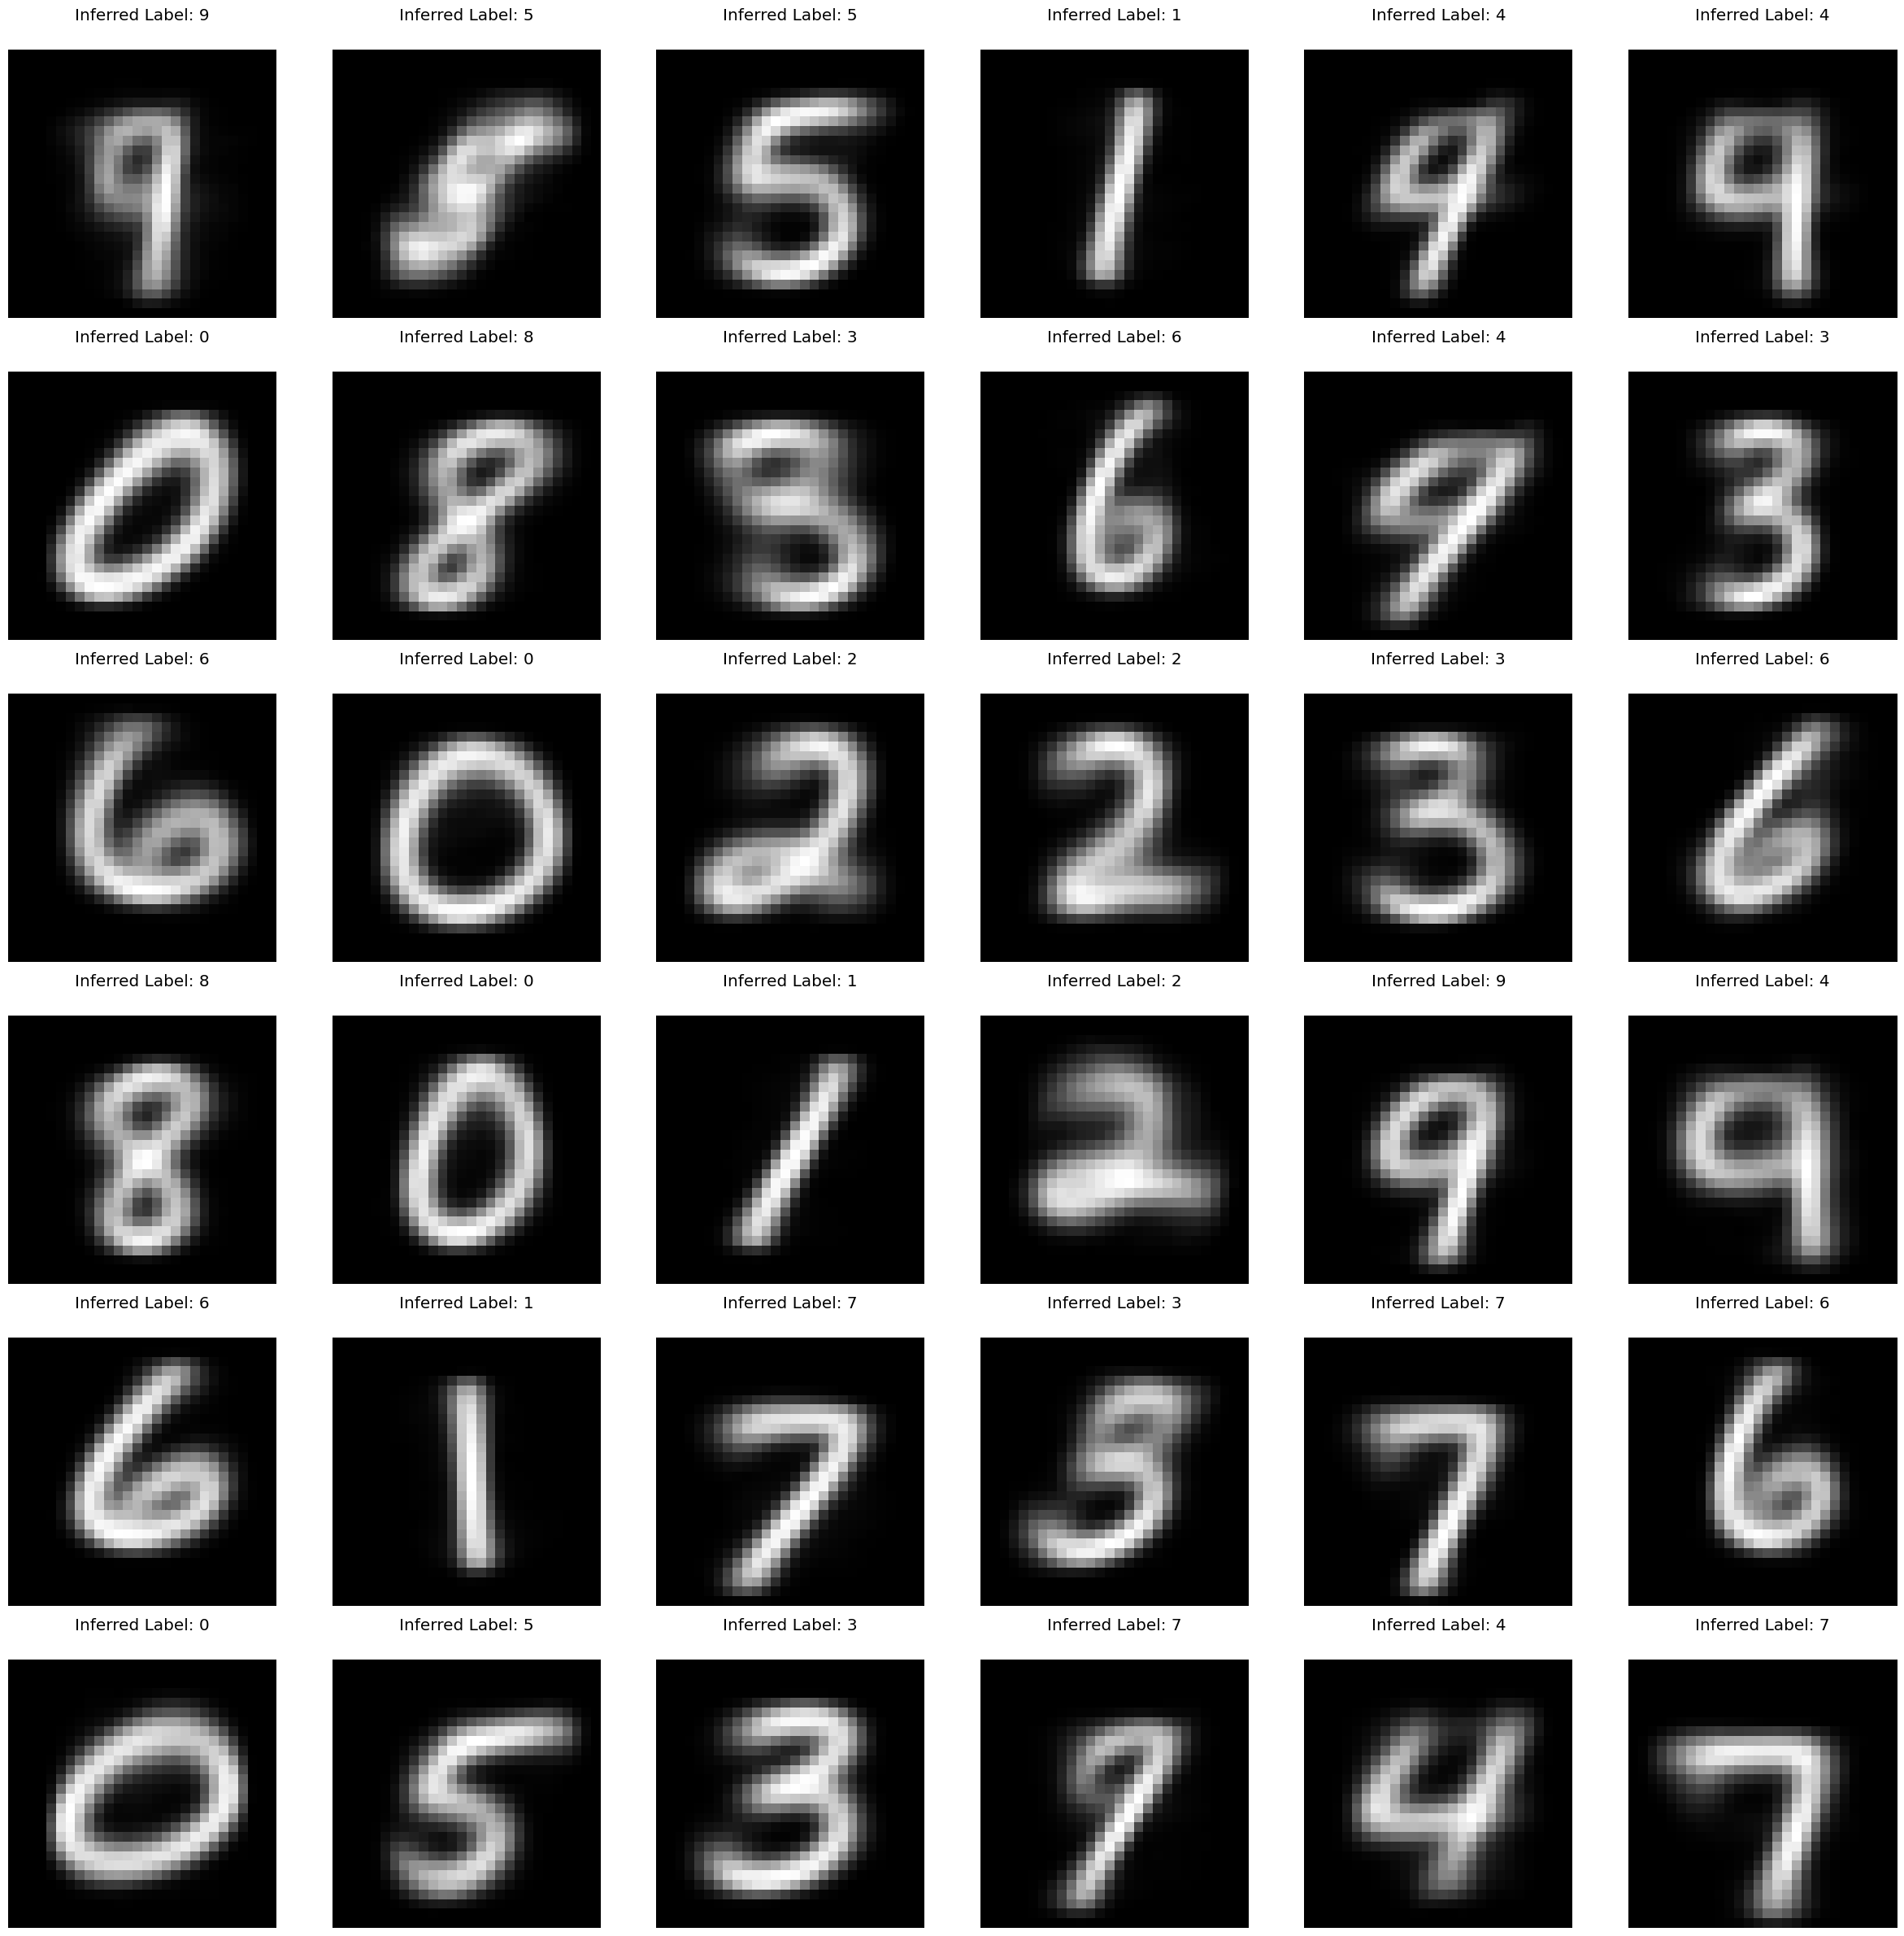

In [235]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (30, 30))
plt.gray()
font = {'size': 12}
plt.rc('font', **font)
# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

## Save Our Model for Future Use

Last step. We've got a model we like, how do we save it for later? Well we're in a pickle... wait, pickle is the answer!

The *pickle* library can serialize and unserialize python data. Basically it can take the binary representation of a Python object and save it in a file. It can then unserialize it later and make it a Python object again. It's kind of like a snapshot of any given variable in your Python script that you can freeze and unfreeze as you'd like. Let's use it on our kmeans classifier.

In [237]:
import pickle

# Initialize and fit KMeans algorithm
kmeans_final = MiniBatchKMeans(n_clusters = 256, random_state=random_state)
kmeans_final.fit(X)

with open("model.pkl", "wb") as f:
    pickle.dump(kmeans_final, f)

We've got a file now, but let's open it up and double check that it will work the same way when we're done.

In [239]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)
    cluster_labels = infer_cluster_labels(model, Y)
    predicted_Y = infer_data_labels(model.labels_, cluster_labels)

    # calculate and print accuracy
    print(f'Accuracy: {metrics.accuracy_score(Y, predicted_Y)}')
        

Accuracy: 0.9023166666666667


That looks good to me! That's a wrap on K-Means. To recap:

### 1. Initial Setup
- **Library Imports**: Initiated the analysis by importing essential libraries and the MNIST dataset, setting the stage for subsequent tasks.

### 2. Data Visualization
- **Understanding the Dataset**: Employed visualizations to gain insights into the structure of the MNIST digits, which is crucial for informed modeling.

### 3. Initial Application of K-Means
- **Challenges Encountered**: The initial application of K-Means faced difficulties with the data format and scale, highlighting the need for preprocessing.

### 4. Data Preprocessing
- **Reshaping**: Transformed the dataset from 2D images into 1D arrays to accommodate the algorithm's requirements.
- **Normalization**: Adjusted pixel values to a normalized scale of 0 to 1 to enhance algorithm performance.

### 5. Application of MiniBatchKMeans
- **Optimization for Large Datasets**: Integrated MiniBatchKMeans, which is more suitable for handling the voluminous MNIST dataset.

### 6. Model Tuning
- **Cluster Optimization**: Conducted experiments with different numbers of clusters to refine the model's accuracy and efficiency.

### 7. Label Inference Mechanism
- **Enhancing Interpretability**: Developed a method to map the most frequent actual labels to each cluster, improving the interpretability of the results.

### 8. Serialization of the Model
- **Persistence of the Model**: Utilized pickle to serialize the optimized model, ensuring it can be stored and reused effectively.

### 9. Model Verification
- **Consistency Check**: Reloaded and tested the serialized model to confirm its performance remains consistent post-serialization.

### 10. Achieving Desired Accuracy
- **Final Model Performance**: Achieved an approximate accuracy of 90%, marking a successful application of K-Means to the MNIST dataset.

Next up, we'll explore deep learning models to hopefully increase our accuracy.